We experimented with Multiple Linear Regression, Random Forest, and LightGBM to compare performance. LightGBM achieved the best accuracy, so we report and use only the LightGBM model below. LightGBM is well-suited for tabular data with categorical features, as it can handle categorical variables directly without manual one-hot encoding.

In [1]:
import pandas as pd
import numpy as np
import optuna
from optuna.logging import set_verbosity, WARNING
set_verbosity(WARNING)
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')
import joblib
import pickle

In [2]:
# Load CSV file
df = pd.read_csv('model_df.csv')

# Parse datetime column and sort chronologically
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2419415, 16)


,datetime,station,lat,lon,station_hour_demand_24,station_dow_demand_24,station_month_demand_24,hour,dow,month,is_holiday,temperature,feels_like,wind_speed,bad_weather,total_demand
0,2024-01-01,de la Commune / St-Sulpice,45.504242,-73.553469,7.038627,13.402640,1.803175,0,1,1,1,-4.8,-9.0,10,0,3
1,2024-01-01,Lajeunesse / Villeray,45.542182,-73.622687,3.825397,5.982383,2.218310,0,1,1,1,-4.8,-9.0,10,0,3
2,2024-01-01,Métro Parc (Hutchison / Ogilvy),45.530351,-73.624392,3.088235,7.790879,1.582569,0,1,1,1,-4.8,-9.0,10,0,1
3,2024-01-01,Métro Sherbrooke (de Rigaud / Berri),45.518143,-73.568004,8.451104,11.109174,3.005758,0,1,1,1,-4.8,-9.0,10,0,3
4,2024-01-01,Aylwin / Ontario,45.544283,-73.545442,7.276224,10.869776,1.989011,0,1,1,1,-4.8,-9.0,10,0,3


In [3]:
# Define features and targets
categorical_features = ['station', 'hour', 'dow', 'month']
for col in categorical_features: 
    df[col] = df[col].astype("string")      
    df[col] = df[col].astype("category") # Convert to pandas category
    
binary_features = ['is_holiday', 'bad_weather']
numeric_features = ['station_hour_demand_24', 'station_dow_demand_24', 'station_month_demand_24', 'temperature', 'feels_like', 'wind_speed']

all_features = categorical_features + binary_features + numeric_features

# Target variable
target = 'total_demand'

In [4]:
# Split the dataset chronologically
n_total = len(df)

# Define periods
periods = {
    "2024": df["datetime"].dt.year == 2024,
    "2025-05": (df["datetime"].dt.year == 2025) & (df["datetime"].dt.month == 5),
    "2025-10": (df["datetime"].dt.year == 2025) & (df["datetime"].dt.month == 10),
}

# Print percentages
for name, mask in periods.items():
    pct = mask.sum() / n_total * 100
    print(f"{name}: {pct:.2f}%")

2024: 83.05%
2025-05: 8.77%
2025-10: 8.18%


In [5]:
# Train on all 2024 data, validate on May 2025, and test on Oct 2025
train_df = df[df["datetime"].dt.year == 2024].copy()
val_df = df[(df["datetime"].dt.year == 2025) & (df["datetime"].dt.month == 5)].copy()
test_df = df[(df["datetime"].dt.year == 2025) & (df["datetime"].dt.month == 10)].copy()

# Print split proportions
for name, part in [("train_df", train_df), ("val_df", val_df), ("test_df", test_df)]:
    print(f"{name}: {len(part)} rows ({len(part)/n_total*100:.2f}%)")

# Prepare feature matrices and target vectors
X_train = train_df[all_features]
y_train = train_df[target]

X_val = val_df[all_features]
y_val = val_df[target]

X_test = test_df[all_features]
y_test = test_df[target]

train_df: 2009290 rows (83.05%)
val_df: 212109 rows (8.77%)
test_df: 198016 rows (8.18%)


In [6]:
# Create LightGBM datasets
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    feature_name=all_features,
    categorical_feature=categorical_features,
    free_raw_data=False
)

val_data = lgb.Dataset(
    X_val,
    label=y_val,
    feature_name=all_features,
    categorical_feature=categorical_features,
    reference=train_data,
    free_raw_data=False
)

In [7]:
# Bayesian hyperparameter search
N_TRIALS = 40
NUM_BOOST_ROUND = 8000
EARLY_STOPPING_ROUNDS = 200

base_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "seed": 42,
    "feature_pre_filter": False,
    "force_row_wise": True,
    "num_threads": -1,
    "max_bin": 255
}

def objective(trial: optuna.trial.Trial) -> float:
    # Tune the most impactful parameters first
    params = {
        **base_params,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 2000, log=True),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-3, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
    }

    # Train with early stopping on validation set (prevents overfitting + saves time)
    booster = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[val_data],
        valid_names=["val"],
        callbacks=[
            lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False),
            lgb.log_evaluation(period=0),
        ],
    )

    val_rmse = booster.best_score["val"]["rmse"]

    val_pred = booster.predict(X_val, num_iteration=booster.best_iteration)
    val_r2 = r2_score(y_val, val_pred)

    # Store helpful metadata inside the trial for later inspection
    trial.set_user_attr("best_iteration", booster.best_iteration)
    trial.set_user_attr("val_rmse", val_rmse)
    trial.set_user_attr("val_r2", val_r2)
    return val_rmse

study = optuna.create_study(direction="minimize", study_name="lgbm_bixi_demand")

pbar = tqdm(total=N_TRIALS, desc="Hyperparameter search", leave=True)

def on_trial_complete(study: optuna.Study, trial: optuna.trial.FrozenTrial):
    # Update progress bar
    pbar.update(1)
    pbar.set_postfix(best_rmse=f"{study.best_value:.4f}")

study.optimize(objective, n_trials=N_TRIALS, callbacks=[on_trial_complete], show_progress_bar=False)

pbar.close()

best_iter = study.best_trial.user_attrs.get("best_iteration", None)
best_rmse = study.best_trial.user_attrs.get("val_rmse", None)
best_r2 = study.best_trial.user_attrs.get("val_r2", None)

print("\nBest validation RMSE:", best_rmse)
print("Best validation R^2:", round(best_r2, 4) if best_r2 is not None else None)

print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

print("Best iteration (from early stopping):", best_iter)

Hyperparameter search:   0%|          | 0/40 [00:00<?, ?it/s]


Best validation RMSE: 5.751920950360071
Best validation R^2: 0.6361
Best params:
  learning_rate: 0.013526953170987859
  num_leaves: 256
  max_depth: 12
  min_data_in_leaf: 69
  min_sum_hessian_in_leaf: 4.707959099202557
  feature_fraction: 0.7580606760952284
  bagging_fraction: 0.9634260983179286
  bagging_freq: 2
  lambda_l1: 7.624449358562919
  lambda_l2: 3.872391465423688
  min_gain_to_split: 0.5501558844179344
Best iteration (from early stopping): 757


In [8]:
# Train final model with best params (train on 2024 only), then evaluate
# Best params from Optuna
base_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "seed": 42,
    "feature_pre_filter": False,
    "force_row_wise": True,
    "num_threads": -1,
    "max_bin": 255
}

manual_best_params = {
    "learning_rate": 0.013526953170987859,
    "num_leaves": 256,
    "max_depth": 12,
    "min_data_in_leaf": 69,
    "min_sum_hessian_in_leaf": 4.707959099202557,
    "feature_fraction": 0.7580606760952284,
    "bagging_fraction": 0.9634260983179286,
    "bagging_freq": 2,
    "lambda_l1": 7.624449358562919,
    "lambda_l2": 3.872391465423688,
    "min_gain_to_split": 0.5501558844179344,
}

best_params = {**base_params, **manual_best_params}

# Use the best iteration found by early stopping during search
best_iter = 757
num_boost_round = int(best_iter)

# Rebuild training Dataset
final_train_data = lgb.Dataset(
    X_train,
    label=y_train,
    feature_name=all_features,
    categorical_feature=categorical_features,
    free_raw_data=False,
)

# Train with a small eval set just for logging (no early stopping needed if we fix num_boost_round)
final_booster = lgb.train(
    best_params,
    final_train_data,
    num_boost_round=num_boost_round,
    valid_sets=[final_train_data, val_data],
    valid_names=["train", "val"],
    callbacks=[lgb.log_evaluation(period=200)],
)

def regression_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return r2, rmse, mae

# Predict using the trained number of iterations
train_pred = final_booster.predict(X_train, num_iteration=num_boost_round)
val_pred   = final_booster.predict(X_val,   num_iteration=num_boost_round)
test_pred  = final_booster.predict(X_test,  num_iteration=num_boost_round)

r2_tr, rmse_tr, mae_tr = regression_metrics(y_train, train_pred)
r2_va, rmse_va, mae_va = regression_metrics(y_val, val_pred)
r2_te, rmse_te, mae_te = regression_metrics(y_test, test_pred)

print(f"Train(2024)| R^2: {r2_tr:.4f} | RMSE: {rmse_tr:.4f} | MAE: {mae_tr:.4f}")
print(f"Val  (2025)| R^2: {r2_va:.4f} | RMSE: {rmse_va:.4f} | MAE: {mae_va:.4f}")
print(f"Test (2025)| R^2: {r2_te:.4f} | RMSE: {rmse_te:.4f} | MAE: {mae_te:.4f}")

[200]	train's rmse: 5.30178	val's rmse: 5.82985
[400]	train's rmse: 4.88266	val's rmse: 5.75887
[600]	train's rmse: 4.73151	val's rmse: 5.75696
Train(2024)| R^2: 0.8029 | RMSE: 4.6615 | MAE: 3.0972
Val  (2025)| R^2: 0.6361 | RMSE: 5.7519 | MAE: 3.7672
Test (2025)| R^2: 0.6838 | RMSE: 5.9566 | MAE: 3.8900


**Interpretation:** The model performs strongest on the 2024 training set and generalizes reasonably to future months. 

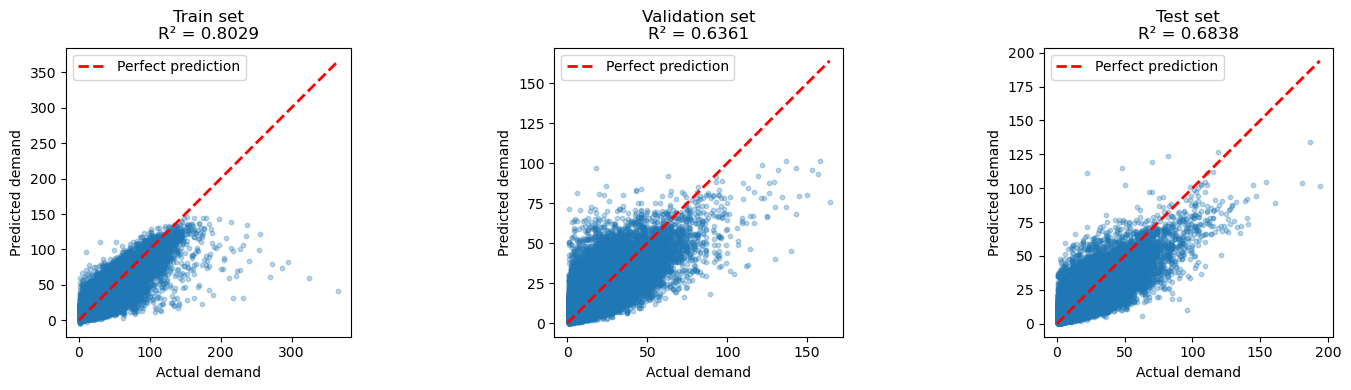

In [9]:
# Actual vs. predicted scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    ("Train", y_train, train_pred, r2_tr),
    ("Validation", y_val, val_pred, r2_va),
    ("Test", y_test, test_pred, r2_te),
]

for ax, (name, y_true, y_pred, r2) in zip(axes, datasets):
    ax.scatter(y_true, y_pred, alpha=0.3, s=10)

    # Diagonal reference line (perfect predictions)
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], "r--", linewidth=2, label="Perfect prediction")

    ax.set_xlabel("Actual demand")
    ax.set_ylabel("Predicted demand")
    ax.set_title(f"{name} set\nR² = {r2:.4f}")
    ax.legend(loc="upper left")
    ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=150, bbox_inches="tight")
plt.show()

**Interpretation:** Points cluster around the perfect-prediction line but spread increases from train to val/test, indicating noisier generalization. The model also tends to underpredict high-demand hours, showing difficulty capturing extreme peaks.

In [10]:
# Get feature importance by gain
importance_gain = final_booster.feature_importance(importance_type='gain')
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance (Gain)': importance_gain
}).sort_values('Importance (Gain)', ascending=False)

print("Feature Importance (Gain-based):")
for _, row in feature_importance_df.iterrows():
    print(f"  {row['Feature']:30s} {row['Importance (Gain)']:>10.2f}")

Feature Importance (Gain-based):
  station_hour_demand_24         2402256257.06
  station_month_demand_24        1146149102.37
  hour                           764058018.56
  temperature                    471481563.67
  station                        442787069.99
  month                          284757660.52
  dow                            228827951.52
  feels_like                     222269849.20
  station_dow_demand_24          215936052.84
  bad_weather                    117670317.62
  wind_speed                     38548458.55
  is_holiday                     26020336.13


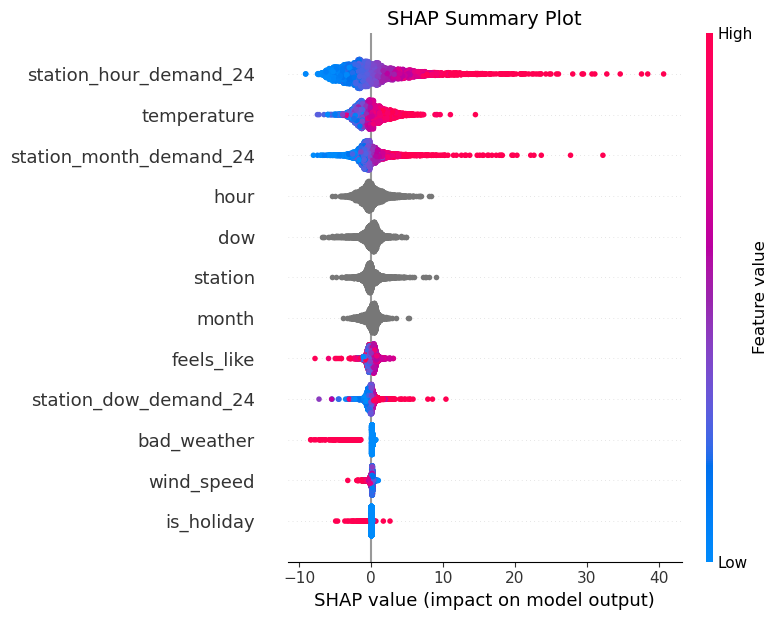

In [16]:
# SHAP plot
shap_sample_size = 5000
X_shap = X_train.sample(n=shap_sample_size, random_state=42)

# Ensure same column order as training
X_shap = X_shap[all_features].copy()

# Ensure categorical dtypes match training setup
categorical_features = ['station', 'hour', 'dow', 'month']
for col in categorical_features:
    X_shap[col] = X_shap[col].astype("string").astype("category")

# SHAP
explainer = shap.TreeExplainer(final_booster)
shap_values = explainer.shap_values(X_shap)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=all_features, show=False)
plt.title("SHAP Summary Plot", fontsize=14)
plt.tight_layout()
plt.show()

**Interpretation:** The model's demand predictions are driven mainly by the 2024 station-level baseline features, especially **station_hour_demand_24** and **station_month_demand_24**, and by **temperature**, where higher values generally push predicted demand upward. **hour**, **dow**, **station**, and **month** also influence predictions but show smaller overall impact. **feels_like** adds a weaker secondary weather effect. **bad_weather = 1** tends to reduce predicted demand, **wind_speed** usually has a small negative influence, and **is_holiday = 1** typically lowers predicted demand as well.

In [11]:
# Save model and metadata for Streamlit app
# Save model
final_booster.save_model("model_lightgbm.txt")
print("Saved model_lightgbm.txt")

# Save metadata
station_sorted = df["station"].drop_duplicates().sort_values().tolist()

# Station demand baselines 
station_hour_demand_24 = (
    df.groupby(["station", "hour"])["station_hour_demand_24"]
    .mean()
    .to_dict()
)

station_dow_demand_24 = (
    df.groupby(["station", "dow"])["station_dow_demand_24"]
    .mean()
    .to_dict()
)

station_month_demand_24 = (
    df.groupby(["station", "month"])["station_month_demand_24"]
    .mean()
    .to_dict()
)

# Global fallback means
global_hour_demand_24  = df["station_hour_demand_24"].mean()
global_dow_demand_24   = df["station_dow_demand_24"].mean()
global_month_demand_24 = df["station_month_demand_24"].mean()

meta = {
    "all_features": all_features, "categorical_features": categorical_features,
    "station": station_sorted,
    "station_hour_demand_24": station_hour_demand_24, "station_dow_demand_24": station_dow_demand_24, "station_month_demand_24":station_month_demand_24,
    "global_hour_demand_24": global_hour_demand_24, "global_dow_demand_24": global_dow_demand_24, "global_month_demand_24": global_month_demand_24
}

with open("meta_lightgbm.pkl", "wb") as f:
    pickle.dump(meta, f)
print("Saved meta_lightgbm.pkl")

Saved model_lightgbm.txt
Saved meta_lightgbm.pkl
